In [3]:
# exploring this concept:
# https://documentation.dataspace.copernicus.eu/APIs/openEO/openeo-community-examples/python/SurfaceSoilMoisture/SoilMoisture.html

In [5]:
import openeo
import openeo.processes 

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=JNAG-JRJK 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


In [16]:
# (Metropolitan Golf Links)
aoi = {
    "type": "Polygon",
    "coordinates": [[
        [-122.2081, 37.7394],
        [-122.2081, 37.7494],
        [-122.1981, 37.7494],
        [-122.1981, 37.7394],
        [-122.2081, 37.7394]
    ]]
}

s1_ref = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=["2023-01-01", "2024-01-01"],
    spatial_extent=aoi,
    bands=["VV", "VH"],
)

s1_ref = s1_ref.sar_backscatter(coefficient="sigma0-ellipsoid")

In [17]:
s1_cur = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=["2024-01-01", "2024-01-30"],
    spatial_extent=aoi,
    bands=["VV", "VH"],
)
s1_cur = s1_cur.sar_backscatter(coefficient="sigma0-ellipsoid")

In [18]:
s1_cur = s1_cur.reduce_dimension(dimension='t',reducer='last')
dry_ref = s1_ref.reduce_dimension(dimension='t',reducer='min')
wet_ref = s1_ref.reduce_dimension(dimension='t',reducer='max')

In [19]:
SSM = (s1_cur-dry_ref)/(wet_ref-dry_ref)

In [20]:
average_ref = s1_ref.reduce_dimension(dimension='t',reducer='mean')
average_ref = average_ref.apply(process=lambda data: 10 * openeo.processes.log(data, base=10))

In [21]:
# mask permanent water
VV = average_ref.band("VV")
mask = ((VV > -6) | (VV < -17))
SSM = SSM.mask(mask)

In [22]:
SSM.execute_batch(title="Surface Soil Moisture Metro Golf Links", outputfile="MetroGolfLinksSoilMoisture.nc")

0:00:00 Job 'j-250105dd74494aaba6959cc0e52adeed': send 'start'
0:00:18 Job 'j-250105dd74494aaba6959cc0e52adeed': created (progress 0%)
0:00:23 Job 'j-250105dd74494aaba6959cc0e52adeed': created (progress 0%)
0:00:30 Job 'j-250105dd74494aaba6959cc0e52adeed': created (progress 0%)
0:00:38 Job 'j-250105dd74494aaba6959cc0e52adeed': created (progress 0%)
0:00:48 Job 'j-250105dd74494aaba6959cc0e52adeed': created (progress 0%)
0:01:01 Job 'j-250105dd74494aaba6959cc0e52adeed': created (progress 0%)
0:01:17 Job 'j-250105dd74494aaba6959cc0e52adeed': created (progress 0%)
0:01:37 Job 'j-250105dd74494aaba6959cc0e52adeed': created (progress 0%)
0:02:01 Job 'j-250105dd74494aaba6959cc0e52adeed': running (progress N/A)
0:02:32 Job 'j-250105dd74494aaba6959cc0e52adeed': running (progress N/A)
0:03:10 Job 'j-250105dd74494aaba6959cc0e52adeed': finished (progress 100%)


<BatchJob job_id='j-250105dd74494aaba6959cc0e52adeed'>

In [14]:
import matplotlib.pyplot as plt
import xarray as xr

Text(0.5, 1.0, 'Surface Soil Moisture Metro Golf Links')

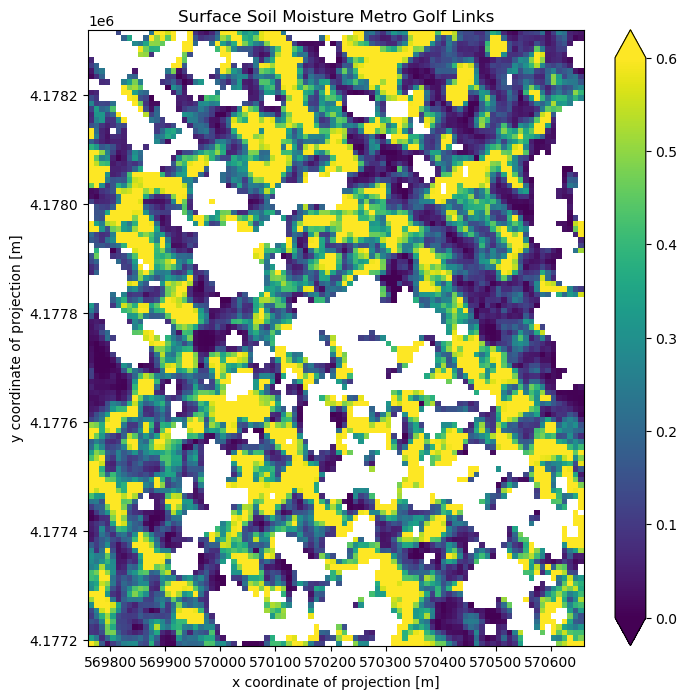

In [23]:
ds = xr.load_dataset("MetroGolfLinksSoilMoisture.nc")
data = ds[["VV"]].to_array(dim="bands")
fig, axes = plt.subplots(ncols=1, figsize=(8, 8), dpi=100, sharey=True)
data[0].plot.imshow(ax=axes, vmax=0.6, vmin=0)
axes.set_title("Surface Soil Moisture Metro Golf Links")